# **Chap 6：计算机视觉**

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import time
from source.code import ch6
from source.code import utils

2023-05-14 10:14:55.443868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 10:14:55.595358: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-14 10:14:55.624934: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-14 10:14:56.300416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=1)

## **6.3 目标检测模型**

### **6.3.1 单发多框检测 SSD**

我们介绍一种简单，快速且被广泛使用的目标检测模型，**单发多框检测 SSD**，本节中介绍的模型设计原则和细节也可以推广到其他模型，下图给出了 SSD 的模型设计思路：
* 模型前部主要由**基础网络**组成，后面是几个**多尺度特征块**
* **基础网络用于从输入图像中提取特征**，例如使用深度 CNN，例如 SSD 使用了去除最后全连接层的 VGGNet
* 我们可以设计 CNN **使输出的高宽较大**，这样我们**基于该层特征图生成的锚框数量较多**，可以用来**检测尺寸较小的目标**
* 后续的多尺度特征块**将上一层提供的特征图高宽减小**，使每个单元有**更大的感受野**，用来**检测更大范围的目标**

<img src="../source/Chap6/SSD.svg" width=700>

因此，**SSD 依靠多层的多尺度特征块，在不同层生成不同大小的锚框，实现多尺度目标检测**，接下来我们要解决两个问题：
* 如何预测目标类别 `class`
* 如何预测偏移量 `offset`

**(1) 类别预测层**

假设**目标类别数量**为 $C$，包括背景在内，锚框就会有 $C + 1$ 个类别，其中**类别 0 是背景**，在某个尺度的特征图上，假设特征图的高宽为 $h\times w$，如果以其每个像素中心生成 $a$ 个锚框，那么我们就需要对 $hwa$ 个锚框进行分类
* 这时候如果**使用全连接层作为类别的输出网络**，非常容易**导致参数过多**
* 在 CNN 的学习中，**NiN 采用了** $1\times 1$ **卷积层代替全连接层**，在**通道维度上变换**，利用通道输出类别预测，这里我们也可以采用类似的技巧
    * 类别预测时，**通过卷积层变换，使得输出和输入具有相同的尺寸**，保持高宽不变
    * 此时，特征图输入 `X` 上的**空间坐标**就能和输出 `Y` **一一对应**
    * 考虑输入和输出的同一坐标 $(x,y)$，**输出特征图** $(x,y)$ **的通道里包含了以输入特征图** $(x,y)$ **坐标为中心生成的所有锚框的类别预测**，因此，**输出通道的数量应该是** $a\times (C+1)$
    * **输出通道索引** $i(C+1) + j, (0\leq j \leq C)$ 表示索引为 $i, i=0,\cdots,a-1$ 的锚框预测类别为 $j$ 的信息

类别预测层 `ClassPredictor` 通过参数 `num_anchors` 和 `num_classes` 指定 $a,C$
* 它使用填充为 1 的 $3\times 3$ 卷积层，保持输入特征图高宽不变
* 可以使用 `Softmax` 激活，**将 Logits 转换为类别的概率分布**，或者最后再统一处理

In [3]:
class ClassPredictor(tf.keras.layers.Layer):
    def __init__(self, num_anchors : int, num_classes : int, dropout : float=0.0,
                 trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        self.num_anchors = num_anchors
        self.num_classes = num_classes
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.conv = tf.keras.layers.Conv2D(
            filters=num_anchors * (num_classes + 1),kernel_size=3,padding='same')
        # 将形状从 (batch, height, width, num_anchors * (num_classes + 1))
        # 转换为 (batch, height * width * num_anchors, num_classes + 1)
        self.flat = tf.keras.layers.Flatten() # 保留批量维度，合并其余维度
        
    def call(self, inputs : tf.Tensor, flatten : bool=False, **kwargs):
        Y = self.conv(self.dropout(inputs,**kwargs))
        if flatten:
            Y = self.flat(Y)
        return Y

测试 `ClassPredictor` 的计算结果，会看到**输入和输出特征图的高宽保持不变**

In [5]:
# 生成输入
X = tf.random.uniform(shape=(2, 16, 16, 5)) # (batch, height, width, num_channels)
# 实例化类别预测层
cls_pred = ClassPredictor(num_anchors=5, num_classes=3)
cls_pred(X,flatten=False).shape

TensorShape([2, 16, 16, 20])

当然，我们可以**合并后面三个维度**，只保留批量维度
* 该操作的目的在于后续可以与**边界框预测**的结果在特征维度上（`axis = 1`）拼接，便于模型处理

In [6]:
cls_pred(X,flatten=True).shape

TensorShape([2, 5120])

**(2) 边界框预测层**

边界框预测层的**设计与类别预测层的设计类似**，不过我们需要**为每个锚框预测 4 个偏移量**，而不是预测类别，`BBoxPredictor` 实现了边界框预测

In [7]:
class BBoxPredictor(tf.keras.layers.Layer):
    def __init__(self, num_anchors : int, dropout : float=0.0,
                 trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        self.num_anchors = num_anchors
        # 每个锚框预测 4 个偏移量，因此输出通道数为 `num_anchors * 4`
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.conv = tf.keras.layers.Conv2D(
            filters=num_anchors * 4, kernel_size=3,padding='same')
        # 将形状从 (batch, height, width, num_anchors * (num_classes + 1))
        # 转换为 (batch, height * width * num_anchors * (num_classes + 1))
        self.flat = tf.keras.layers.Flatten() # 保留批量维度，合并其余维度
        
    def call(self, inputs : tf.Tensor, flatten : bool=False, **kwargs):
        Y = self.conv(self.dropout(inputs,**kwargs))
        if flatten:
            Y = self.flat(Y)
        return Y

**(3) 连接多尺度的预测**

SSD 将基于不同尺寸的特征图做出预测，而**在不同的尺寸下，特征图的形状，以及以某一像素为中心的锚框的数量可能有所不同**，这使得多尺度预测输出的形状是不一样的

以锚框类别预测为例，假设我们得到了两个不同尺寸的预测结果 `Y1, Y2`，它们的**高宽不同**，且假设**基于更大的特征图，生成了更多的锚框，而基于更小的特征图，生成了更少的锚框**，观察它们的输出形状：

In [8]:
# 较大的特征图，锚框数量为 5
X1 = tf.random.uniform(shape=(2, 20, 20, 8))
Y1 = ClassPredictor(num_anchors=5, num_classes=10)(X1,flatten=False)

# 较小的特征图，锚框数量为 3
X2 = tf.random.uniform(shape=(2, 10, 10, 16))
Y2 = ClassPredictor(num_anchors=3, num_classes=10)(X2,flatten=False)
Y1.shape, Y2.shape

(TensorShape([2, 20, 20, 55]), TensorShape([2, 10, 10, 33]))

对于多尺度预测的输出 `Y1, Y2`，**除了批量大小维度相同，其他三个维度都可能有不同的尺寸**
* 为了便于后续模型的统一处理，提高计算效率，我们需要将多尺度预测结果拼接
* 为了实现拼接，我们需要**将多尺度的输出结果拉直为向量**，形状变为 `(batch_size, height * width * num_channels)`
* 变换后，来自两个尺度的输出就可以在特征维度（`axis = 1`）维度拼接了

`ConcatPreds` 计算曾仅实现拼接操作，它不包含任何模型参数

In [9]:
class ConcatPreds(tf.keras.layers.Layer):
    def __init__(self, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
    
    def call(self, preds : list, *args, **kwargs):
        # preds : 需要进行拼接的多尺度预测结果，用列表存储
        return tf.concat(preds, axis=1)

在做出预测时，我们指定 `flatten = True`，就可以执行拼接操作了

In [10]:
Y1 = ClassPredictor(num_anchors=5, num_classes=10)(X1,flatten=True)
Y2 = ClassPredictor(num_anchors=3, num_classes=10)(X2,flatten=True)
ConcatPreds()([Y1, Y2]).shape

TensorShape([2, 25300])

**(4) 高宽减半的特征块**

为了**在多个尺度下检测目标，我们定义了高和宽减半块** `DownSampleBlock`：
* `DownSampleBlock` 通过一系列卷积操作将输入特征图的**高度和宽度减半**
* 每个块儿包含**两个填充为 1 的** $3\times 3$ **卷积层**和步幅为 2 的 $2\times 2$ 最大汇聚层构成，**卷积算子用于加工特征，最大汇聚层真正起到高宽减半的作用**，这其实**是 VGGNet 中的卷积块**
* 思考：经过一个 `DownSampleBlock`，其**输出的每个像素对于该层输入的感受野是多大**？
* 没经过一个高宽减半的特征块，特征图的感受野就会获得扩大，能**用来检测更大范围的目标**

In [11]:
class DownSampleBlock(tf.keras.layers.Layer):
    def __init__(self, out_channels : int, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable, name, dtype, dynamic, **kwargs)
        self.block = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=out_channels, kernel_size=3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(filters=out_channels, kernel_size=3, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        ])
    
    def call(self, inputs : tf.Tensor, **kwargs):
        return self.block(inputs,**kwargs)

In [12]:
# 生成输入
X = tf.random.uniform(shape=(2, 16, 16, 8)) # (batch, height, width, num_channels)
# 实例化下采样块
DownSampleBlock(out_channels=16)(X).shape

TensorShape([2, 8, 8, 16])

**(5) 基础网络块**

基本网络块用于从输入图像中抽取特征，可以**使用没有全连接层的 VGGNet，ResNet 等经典架构**
* 为了计算简洁，我们构造了一个小的基础网络，该网络串联3个高和宽减半块，并逐步将通道数翻倍

In [13]:
def create_base_model(input_size : tuple, channel_list : list=[16, 32, 64]):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_size),
    ])
    for channels in channel_list:
        # 直接使用 DownSampleBlock 的接口
        model.add(ch6.DownSampleBlock(out_channels=channels).block)
    return model

我们来测试基础网络块的计算结果，可以看到**输出特征图的尺寸是** $32\times 32$

In [14]:
# 实例化模型
model = create_base_model(input_size=(256, 256, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 128, 128, 16)      2896      
                                                                 
 sequential_3 (Sequential)   (None, 64, 64, 32)        14144     
                                                                 
 sequential_4 (Sequential)   (None, 32, 32, 64)        55936     
                                                                 
Total params: 72,976
Trainable params: 72,528
Non-trainable params: 448
_________________________________________________________________


**(5) 搭建完整模型**

完整的 SSD 模型包含 5 个模块：
* 第 1 块即**基础模型**，用于特征提取
* 第 2 至 4 块是**高宽减半的特征块**
* 第 5 块使用**全局最大池化层将高宽降低到 1**
* **每一块生成的特征图都需要用于生成锚框，然后预测锚框类别和偏移量**

我们为每个块定义**目标检测专用的推理函数**
* 与 CNN 不同，模型的 `call()` 只能计算出特征图，我们**还需要生成锚框** `anchors`，以及**基于这些锚框预测类别** `cls_preds` 和**偏移量** `offset_preds`

In [84]:
def block_call(X : tf.Tensor, block : tf.keras.layers.Layer, sizes, ratios,
               cls_predictor : ch6.ClassPredictor, bbox_predictor : ch6.BBoxPredictor,**kwargs):
    # 计算 block 的输出特征图
    Y = block(X,**kwargs)
    # 生成基于特征图的多尺度锚框
    anchors = ch6.generate_multi_bbox_tf(img=Y, sizes=sizes, ratios=ratios)
    # 生成类别预测结果 和 边界框预测结果
    cls_preds = cls_predictor(Y, flatten=True,**kwargs)
    bbox_preds = bbox_predictor(Y, flatten=True,**kwargs)
    return (Y, anchors, cls_preds, bbox_preds)

我们来测试一下函数 `block_call()` 的工作情况

In [85]:
# 生成输入
X = tf.random.uniform(shape=(2, 32, 32, 3)) # (batch, height, width, num_channels)
# 实例化一个基础模型作为 block
block = create_base_model(input_size=(32, 32, 3))
# 设置尺度参数和宽高比
sizes, ratios = tf.constant([0.2, 0.5]), tf.constant([1, 2, 0.5])
num_anchors = len(sizes) + len(ratios) - 1 # 每个像素生成的锚框数量

# 实例化类别预测层 和 边界框预测层
cls_predictor = ch6.ClassPredictor(num_anchors=num_anchors, num_classes=10)
bbox_predictor = ch6.BBoxPredictor(num_anchors=num_anchors)

# 调用 block_call 函数
output = block_call(X, block, sizes, ratios, cls_predictor, bbox_predictor,training=False)
# 打印输出形状
print("特征图形状：", output[0].shape)
print("锚框形状：", output[1].shape)
print("类别预测结果形状：", output[2].shape)
print("边界框预测结果形状：", output[3].shape)

特征图形状： (2, 4, 4, 64)
锚框形状： (64, 4)
类别预测结果形状： (2, 704)
边界框预测结果形状： (2, 256)


下面，我们定义 `TinySSD` 作为我们简单的 SSD 模型：
* 在多尺度目标检测中，我们一直强调，**越接近顶部的多尺度特征块用于检测越大目标的**
* 因此对于不同块的特征图，我们可以设置不同的尺度参数 `sizes` 和宽高比 `ratios`
    * 随着特征块越接近顶层，尺度参数 `sizes` 应该越大，越接近 1
    * 宽高比 `ratios` 可以保持不变

一种 `sizes` 的生成方法是
* 我们为每个块 `i` 的特征图设计两个尺度参数 `sizes[i][0], sizes[i][1]`
* 首先确认 `sizes[i][0]` 的取值范围，例如取 0.2 到 1.0 之间的五等分点：`[0.2, 0.36, 0.52, 0.68, 0.84]`
* 然后用 `sizes[i][1] = \sqrt{sizes[i][0] * sizes[i+1][0]}` 来确认另一个尺度参数

In [86]:
# 为不同尺度的锚框设置不同的尺度参数
block_sizes = [[0.20, 0.27], [0.36, 0.43], [0.52, 0.60], [0.68, 0.76], [0.84, 0.92]]
block_ratios = [[1, 2, 0.5]] * 5 # 固定宽高比

In [87]:
class TinySSD(tf.keras.Model):
    def __init__(self, input_size : tuple, num_classes : int, 
                 sizes : tf.Tensor, ratios : tf.Tensor, dropout : float=0.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_classes = num_classes
        # 每个像素生成的锚框数量
        self.sizes = sizes
        self.ratios = ratios
        self.num_anchors = [len(sizes[i]) + len(ratios[i]) - 1 for i in range(5)] 

        # 将模型块进行包装
        self.blocks = [
            ch6.create_base_model(input_size=input_size), # 基础模型
            ch6.DownSampleBlock(out_channels=128), # 第一个下采样特征块
            ch6.DownSampleBlock(out_channels=128), # 第二个下采样特征块
            ch6.DownSampleBlock(out_channels=128), # 第三个下采样特征块
            tf.keras.layers.GlobalMaxPooling2D(keepdims=True) # 全局最大池化，注意保持维度
        ]
        # 设置类别预测层 和 边界框预测层
        self.class_predictors = [
            ch6.ClassPredictor(num_anchors=self.num_anchors[i], num_classes=num_classes, dropout=dropout) for i in range(5)
        ]
        self.bbox_predictors = [
            ch6.BBoxPredictor(num_anchors=self.num_anchors[i], dropout=dropout) for i in range(5)
        ]
    
    def call(self, X, training=None, mask=None):
        # 初始化锚框，类别预测结果，边界框预测结果
        anchors, class_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        # 逐层进行预测
        for i in range(5):
            # X 形状：(batch, height, width, num_channels)
            # anchors[i] 形状：(height[i] * width[i] * num_anchors[i], 4)
            # class_preds[i] 形状：(batch, height[i] * width[i] * num_anchors[i] * (num_classes + 1))
            # bbox_preds[i] 形状：(batch, height[i] * width[i] * num_anchors[i] * 4)
            X, anchors[i], class_preds[i], bbox_preds[i] = ch6.block_call(
                X, self.blocks[i], self.sizes[i], self.ratios[i], 
                self.class_predictors[i], self.bbox_predictors[i], training=training
            )

        # 将多尺度的锚框拼接在一起
        anchors = tf.concat(anchors, axis=0) # (num_anchors, 4)
        
        # 拼接多尺度的类别，将类别维度恢复在最后一维，中间维度是多尺度锚框的个数
        class_preds = ch6.ConcatPreds()(class_preds, axis=1)
        class_preds = tf.reshape(class_preds, shape=(class_preds.shape[0], -1, self.num_classes + 1))
        class_preds = tf.nn.softmax(class_preds, axis=-1) # 使用 softmax 将类别预测结果转换为概率
        
        # 拼接多尺度预测的边界框
        bbox_preds = ch6.ConcatPreds()(bbox_preds, axis=1)

        return anchors, class_preds, bbox_preds

我们创建一个模型实例，然后使用它对一个 $256\times 256$ 像素的小批量图像执行前向推理，观察输出结果

In [88]:
# 创建模型，类别数量设置为 3
model = TinySSD(input_size=(256, 256, 3), num_classes=3, 
                sizes=tf.constant(block_sizes), ratios=tf.constant(block_ratios))
# 生成输入
X = tf.random.uniform(shape=(2, 256, 256, 3)) # (batch, height, width, num_channels)
anchors, class_preds, bbox_preds = model(X, training=False)

参与预测的锚框的数量应该等于**五个尺度下，每个尺度图像高宽乘积** $hw$ **和每个像素生成的锚框数量**（这里每一块 `num_anchors[i] = 2 + 3 - 1 = 4`），即 $(32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444$

In [89]:
# 打印输出形状
print("锚框形状：", anchors.shape)
print("类别预测结果形状：", class_preds.shape)
print("边界框预测结果形状：", bbox_preds.shape)

锚框形状： (5444, 4)
类别预测结果形状： (2, 5444, 4)
边界框预测结果形状： (2, 21776)


接下来，我们可以**定义损失函数**和**评价函数**，然后开始训练模型

**(6) 定义损失函数和评价指标**

目标检测有两种类型的损失：
* 第一种**有关锚框类别的损失**，我们可以**使用图像分类问题里一直使用的交叉熵损失函数**来计算
* 第二种**有关正类锚框偏移量的损失**，预测偏移量是一个**回归问题**，可以考虑使用**平方损失**
    * 但是，对于这个回归问题，我们使用 $L_1,L_2$ 结合的**Huber损失**，$L_1$ 损失的加入相比 $L_2$ 损失**更鲁棒**
* 掩码 `bbox_mask` 可以**过滤掉背景锚框和填充锚框**，使它们不参与损失的计算
* 最后损失函数将**类别预测损失和偏移量预测损失相加**

In [90]:
class SSDLoss(tf.keras.losses.Loss):
    def __init__(self, reduction='none', name=None):
        super().__init__(reduction, name)
        self.class_loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
        self.bbox_loss = tf.keras.losses.Huber(reduction='none')
    
    def __call__(self, cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
        # cls_preds 形状：(batch_size, num_anchors, num_classes + 1)
        # cls_labels 形状：(batch_size, num_anchors)
        # bbox_preds 形状：(batch_size, num_anchors * 4)
        # bbox_labels 形状：(batch_size, num_anchors * 4)
        # bbox_masks 形状：(batch_size, num_anchors * 4)
        cls_loss = self.class_loss(y_true=cls_labels, y_pred=cls_preds)
        cls_loss = tf.reduce_mean(cls_loss, axis=1)
        
        bbox_loss = self.bbox_loss(y_true=bbox_labels * bbox_masks, y_pred=bbox_preds * bbox_masks)
        return cls_loss + bbox_loss

我们可以沿用**准确率评价分类结果**。 由于偏移量使用了 Huber 损失，我们使用**平均绝对误差**来评价边界框的预测结果

In [91]:
def cls_evaluation(cls_preds, cls_labels):
    # cls_preds 形状：(batch_size, num_anchors, num_classes + 1)
    # cls_labels 形状：(batch_size, num_anchors)
    cls_preds = tf.cast(tf.argmax(cls_preds, axis=-1), dtype=tf.int32)
    return tf.reduce_sum(tf.cast(cls_preds == cls_labels,dtype=tf.int32))

def bbox_evaluation(bbox_preds, bbox_labels, bbox_masks):
    # bbox_preds 形状：(batch_size, num_anchors * 4)
    # bbox_labels 形状：(batch_size, num_anchors * 4)
    # bbox_masks 形状：(batch_size, num_anchors * 4)
    return tf.reduce_sum(tf.abs((bbox_labels - bbox_preds) * bbox_masks))

接下来，定义训练函数

In [92]:
def train_SSD(model, train_iter, Epochs : int=10, lr : float=0.001, verbose : int=1):
    loss_func = SSDLoss()
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    
    animator = utils.Animator(xlabel='epoch', xlim=[1, Epochs], ncols=3,
                              legend=(("loss",), ('accuracy',),('bbox mae',)),
                              fmts=(("-",),("m--",),("g-,",)),figsize=(12,3))
    
    # 记录单词处理速度
    speeds = []

    for epoch in range(Epochs):
        start = time.time()
        # 存储每个迭代周期的损失和样本量
        loss_batch, acc_batch, mae_batch = tf.constant(0.0), tf.constant(0), tf.constant(0.0)
        samples_batch, samples = tf.constant(0), tf.constant(0)

        for x_batch, y_batch in train_iter.create_dataset():
            with tf.GradientTape() as tape:
                # 生成多尺度锚框，并为每个锚框预测类别和偏移量
                # anchors 形状：(num_anchors, 4)
                # class_preds 形状：(batch_size, num_anchors, num_classes + 1)
                # bbox_preds 形状：(batch_size, num_anchors * 4)
                anchors, cls_preds, bbox_preds = model(x_batch,training=True)

                # 为每个锚框分配类别和偏移量
                # bbox_labels 形状：(batch_size, num_anchors * 4)
                # bbox_mask 形状：(batch_size, num_anchors * 4)
                # cls_labels 形状：(batch_size, num_anchors)
                bbox_labels, bbox_mask, cls_labels = ch6.multibox_target_tf(anchors, y_batch)

                # 计算损失
                loss = loss_func(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_mask)
                batch_size = tf.shape(loss)[0]
                loss = tf.reduce_mean(loss)
                
            weights = model.trainable_variables
            grads = tape.gradient(loss, weights)
            optimizer.apply_gradients(zip(grads, weights))

            # 计算损失和评估指标
            samples += tf.size(cls_labels)
            samples_batch += batch_size
            loss_batch += loss
            acc_batch += cls_evaluation(cls_preds, cls_labels)
            mae_batch += bbox_evaluation(bbox_preds, bbox_labels, bbox_mask)

        end = time.time()
        speeds.append(samples_batch.numpy() / (end - start))

        # 添加动画
        if epoch == 0 or (epoch + 1) % verbose == 0:
            animator.add(epoch+1,(loss_batch.numpy() / samples_batch.numpy(),),ax=0)
            animator.add(epoch+1,(acc_batch.numpy() / samples.numpy(),),ax=1)
            animator.add(epoch+1,(mae_batch.numpy() / (samples.numpy()*4),),ax=2)
        
    print(f"平均 {np.mean(speeds):.1f} 样本/秒")
    return model

In [79]:
# 加载数据集
batch_size = 32
path = "../source/data/cv/fruit_mini/"
train_iter = ch6.DetectionDataLoader(path,dataset="train", batch_size=batch_size)
valid_iter = ch6.DetectionDataLoader(path,dataset="valid", batch_size=batch_size)

# 为不同尺度的锚框设置不同的尺度参数
# 为不同尺度的锚框设置不同的尺度参数
block_sizes = tf.constant([[0.20, 0.27], [0.36, 0.43], [0.52, 0.60], [0.68, 0.76], [0.84, 0.92]])
block_ratios = tf.constant([[1, 2, 0.5]] * 5) # 固定宽高比
# 创建模型，类别数量设置为 3
model = ch6.TinySSD(input_size=(256, 256, 3), num_classes=3, 
                    sizes=block_sizes, ratios=block_ratios,dropout=0.2)

2023-05-14 12:34:29.556821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-14 12:34:29.746602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-14 12:34:30.001463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-14 12:34:31.149223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


read train dataset with 240 images


2023-05-14 12:34:32.253660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


read valid dataset with 60 images


这个**模型想要取得不错的效果，需要训练比较多的轮次**（实验时大约跑了 1000 轮）
* 下面的图是训练后期 200 次迭代的评估曲线

平均 49.5 样本/秒


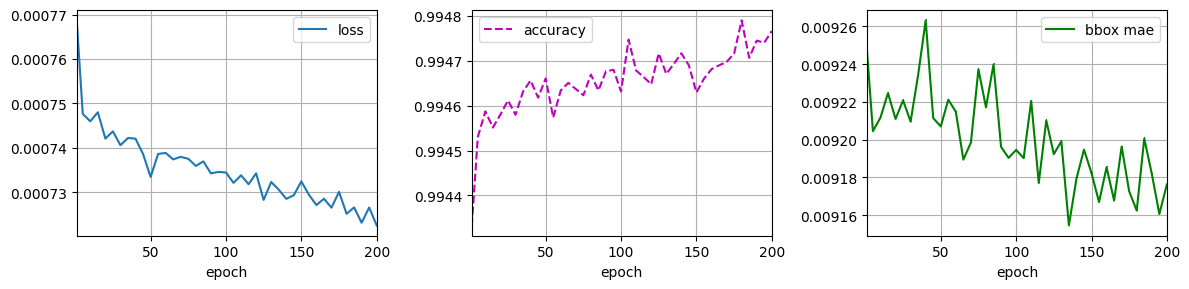

In [49]:
model = ch6.train_SSD(model, train_iter, Epochs=200, lr=0.01, verbose=5)

In [65]:
# 保存模型
# model.save_weights("../source/model/ch6_fruit_mini_detection_ssd.h5")

**(7) 进行预测**

在预测阶段，我们希望能把图像里面所有我们感兴趣的目标检测出来
* 使用 `multibox_detection` 函数，我们可以**根据锚框及其预测偏移量得到预测边界框**
* 然后，**通过非极大值抑制来移除相似的预测边界框**

In [111]:
def object_detection_predict(X : tf.Tensor, model):
    # X 形状：(height, width, 3)
    # anchors 形状：(num_anchors, 4)
    # class_prods 形状：(1, num_anchors, num_classes + 1)
    # bbox_preds 形状：(1, num_anchors * 4)
    anchors, cls_probs, bbox_preds = model(tf.expand_dims(X, axis=0))

    # 使用非极大值抑制来移除相似的锚框
    # output 形状：(num_anchors, 6)
    output = ch6.multibox_detection(cls_probs, bbox_preds, anchors)[0] # 去除 batch 维度

    # 过滤掉背景类（值为 -1）的预测结果
    non_backgrounds = tf.where(output[:,0] > -1)[:,0]
    return tf.gather(output, non_backgrounds)

In [108]:
def display_object_predict(img, output, label_dict, figsize : tuple=(4,4),
                           threshold : int=5, width : int=256, height : int=256):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    for row in output[0:threshold]:
        label = label_dict[int(row[0])]
        prob = float(row[1])
        bbox = [row[2:6] * tf.constant([width, height, width, height], dtype=tf.float32)]
        ch6.show_bboxes(fig.axes[0], bbox, '%s=%.2f' %(label,prob))

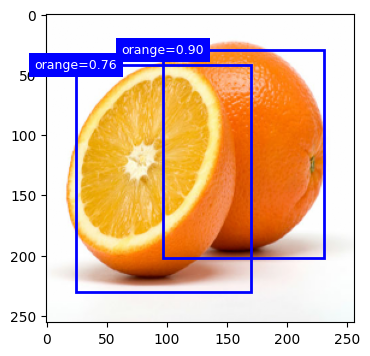

In [50]:
idx = 45
label_dict = ch6.FRUIT_MINI_CLASSES
output  = ch6.object_detection_predict(valid_iter[idx][0], model)
ch6.display_object_predict(valid_iter[idx][0], output, threshold=2, label_dict=label_dict)

----

### **6.3.2 区域卷积神经网络 R-CNN**

另一种将深度学习模型应用到目标检测的主要工作时**区域卷积神经网络**（**Region-based CNN**，简称**R-CNN**），我们在本节只介绍 R-CNN 系列模型的核心思想，就不具体实现了

**(1) R-CNN**

R-CNN 首先从输入图像中选取若干了**提议区域**（锚框就是一种提议区域的选取方法），然后标注这些提议区域的**类别和边界框**（即标注**偏移量**），然后**使用 CNN 在每个提议区域进行前向计算抽取特征**，最后**使用提议区域的高层特征来预测类别和边界框**，如下图所示：

<img src="../source/Chap6/R-CNN.svg" width=700>

R-CNN 在执行时具体包含下面四个步骤：
* 对输入图像使用**选择性搜索**来选取多个**高质量的提议区域**，这些提议区域通常是**多尺度的**（具有不同的形状和大小），然后每个提议区域都被**标注类别和真实边界框**
* 选择一个**预训练的 CNN**，并将其在输出层之前截断（**剥离分类器层，只保留特征提取器**），将提议区域的输入**改变为 CNN 模型所需要的输入尺寸**（例如 `224 * 224`），让后让 CNN 特征提取器进行推理，抽取提议区域的特征
* 将每个**提议区域抽取得到的特征连同标签信息（类别，偏移量）作为一个样本**，设计下游模型，完成类别预测和真实边界框的预测
    * 对 R-CNN 而言，**类别分类器使用了 SVM，真实边界框的预测使用了线性回归模型**

我们注意到：
* R-CNN 只使用一个**预训练的 CNN 模型来抽取特征**，整个 R-CNN 模型没有涉及 CNN 模型本身参数的更新，**它只负责推理**
* **R-CNN 速度缓慢**，我们可能要从一张图像中选取上千个提议区域（例如 SSD 中上千个锚框），**一个样本的计算就需要上千次 CNN 的前向推理来执行目标检测**

**(2) Fast R-CNN**

R-CNN 计算缓慢的原因在于，对于**每个提议区域，CNN 的前向推理是独立的，它们没有共享计算结果**
* 但事实上，这些**区域通常有重叠**，独立的特征抽取会导致重复的计算
* Fast R-CNN 是对 R-CNN 的改进之一，它**仅在整个图像上执行 CNN 的前向推理来抽取特征**

<img src="../source/Chap6/Fast R-CNN.svg" width=400>

Fast R-CNN 的计算逻辑如下：
* Fast R-CNN 用来**提取特征的 CNN 的输入是整个图像**，而不是各个提议区域，此外，**这个 CNN 特征提取器通常会参与训练**，假设输入图像经 CNN 特征提取器处理后的**输出形状为** $h_1\times w_1\times c$
* 假设选择性搜索生成了 $n$ 个提议区域，**这些形状各异的提议区域在卷积神经网络的输出上分别标出了形状各异的兴趣区域**，然后，我们需要将这些兴趣区域**进一步抽取出形状相同的特征**，例如高宽为 $h_2\times w_2$ 的特征，以便于后续连接输出
* 为了实现这一目标，Fast R-CNN 引入了**兴趣区域汇聚层**（**RoI Pooling**），它**将 CNN 的输出和提议区域作为输入**，汇聚得到提议区域抽取的最终特征，形状为 $n\times h_2\times w_2\times c$
* 然后**通过一个全连接层将汇聚层的输出改编维度为** $n\times d$，$d$ **表示隐藏层维度**
* 最后连接实现分类和偏移量预测的下游网络

我们具体来看**兴趣区域汇聚层**的计算逻辑：
* 与 CNN 的汇聚层不同，CNN 的汇聚层通过**固定尺寸的窗口**和**选定的步幅**在输入图像上滑动，然后汇聚抽取特征
* **兴趣区域汇聚层对每个不同形状大小区域的输出形状可以直接指定**

例如，假设我们**指定兴趣区域的输出高宽为** $h_2\times w_2$，则对于任何形状为 $h\times w$ 的兴趣区域窗口输入，**该窗口首先被划分为** $h_2\times w_2$ **的子窗口网格**，每个子窗口的大小约为 $(h/h_2)\times (w/w_2)$
* 在实践中，**子窗口的高度和宽度都应该向上取整**，以保证包含 $h_2\times w_2$ 个子窗口
* 然后在每个子窗口做**最大汇聚**，每个子窗口内的最大元素作为该窗口的输出

因此，**兴趣区域汇聚层可从形状各异的兴趣区域中均抽取出形状相同的特征**

假设对于一个 $4\times 4$ 的输入中，我们选取了左上角 $3\times 3$ 窗口作为兴趣区域，然后我们指定兴趣汇聚层的输出大小为 $2\times 2$，我们就需要将 $3\times 3$ 的窗口划分为 $2\times 2$ 的子窗口，然后在每个子窗口左最大汇聚，得到相应的输出

<img src="../source/Chap6/兴趣区域汇聚.png" width=700>

在实现兴趣区域汇聚时，算法的流程大概如下：
* 假设 CNN 特征提取器的输出大小是 $h_1\times w_1\times c$
* 假设原始图像大小是 $h\times w$， 我们用一个**五维度张量表示一个兴趣区域** $R=[cls, x_1, y_1, x_2, y_2]$
    * $cls$ 是该**提议区域的类别编号**
    * $(x_1,y_1,x_2,y_2)$ 分别**表示提议区域的左上角和右下角坐标**，坐标**用绝对像素位置**表示
    * 即 $0\leq x_1 < x_2\leq w $，$0\leq y_1 < y_2 \leq h$
* **计算输入图像和卷积输出的尺度系数** `spatial_scale`，$(s_h=h_1 / h, s_w=w_1/w)$，例如输入图像是 $h\times w = 40\times 40$，CNN 特征提取的输出是 $h_1\times w_1 = 4\times 4$，则尺度系数等于 $s_h = s_w = 4/40 = 0.1$
* **利用尺度系数，我们可以标定兴趣区域** $(x_1,y_1,x_2,y_2)$ **在 CNN 输出特征图** $(h_1\times w_1)$ **上的位置区域** $S$
    $$
    (\lfloor s_w x_1\rfloor, \lfloor s_h y_1\rfloor, \lfloor s_w x_2\rfloor, \lfloor s_h y_2\rfloor)
    $$
    * 例如对于 $40\times 40$ 的输入图像，以及 CNN 卷积的输出大小为 $4\times 4$，则提议区域 $(0, 10, 30, 30)$ 将会标定出卷积特征图上的区域 $(0, 1, 3, 3)$，即 CNN $4\times 4$ **特征图的下方三行**
* CNN **特征图被标定的位置区域** $S$ **是一个** $(\lfloor s_h (y_2-y_1) \rfloor \times \lfloor s_w (x_2 - x_1)\rfloor)$ **的窗格**，指定兴趣区域池化的**输出大小为** $h_2\times w_2$
* **在区域** $S$ **上作用兴趣区域池化，得到结果**

我们下面实现兴趣区域池化层 `RoIPooling`
* 实现中**我们使用** `@tf.function` **装饰器**和 `tf.map_fn` **技巧来加速计算**

In [45]:
class ROIPooling(tf.keras.layers.Layer):
    """
    ### RoIPooling
    兴趣区域池化层
    """
    def __init__(self, output_shape, **kwargs):
        super(ROIPooling, self).__init__(**kwargs)
        self.o_h, self.o_w = tf.constant(output_shape, dtype=tf.int32)
    
    def call(self, fmaps : tf.Tensor, rois : tf.Tensor, input_shape : tuple=None, **kwargs):
        # f_maps 形状：(batch_size, height, width, channels)
        # rois 形状：(batch_size, num_rois, 4)
        # input_shape = (height, width)
        def task_single_batch(fmap, roi):
            return ROIPooling.roi_pool_single_fmap(fmap, roi, self.o_h, self.o_w)

        # 如果输入的是绝对坐标，则转换为相对坐标
        if input_shape is not None:
            rois = rois / tf.constant([input_shape[0], input_shape[1], 
                                       input_shape[0], input_shape[1]], dtype=tf.float32)

        # 输出形状：(batch_size, num_rois, o_h, o_w, channels)
        return tf.map_fn(lambda x: task_single_batch(x[0], x[1]), (fmaps, rois), dtype=tf.float32)
    
    # 处理单张图片的兴趣区域池化
    @staticmethod
    @tf.function(input_signature=(tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
                                  tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                                  tf.TensorSpec(shape=(), dtype=tf.int32),
                                  tf.TensorSpec(shape=(), dtype=tf.int32)))
    def roi_pool_single_fmap(fmap : tf.Tensor, rois : tf.Tensor, o_h : int, o_w : int):
        # fmap 形状：(height, width, channels)
        # rois 形状：(num_rois, 4)
        def task_single_roi(roi):
            return ROIPooling.roi_pool_single_roi(fmap, roi, o_h, o_w)
        
        # 输出形状：(num_rois, o_h, o_w, channels)
        return tf.map_fn(lambda x : task_single_roi(x), rois, dtype=tf.float32)

    # 对每张图片的每个兴趣区域进行池化
    @staticmethod
    @tf.function(input_signature=(tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
                                  tf.TensorSpec(shape=(4,), dtype=tf.float32),
                                  tf.TensorSpec(shape=(), dtype=tf.int32),
                                  tf.TensorSpec(shape=(), dtype=tf.int32)))
    def roi_pool_single_roi(fmap : tf.Tensor, roi : tf.Tensor, o_h : int, o_w : int):
        # fmap 形状：(height, width, channels)
        # roi = (x1, y1, x2, y2)，形状：(4,)，使用相对坐标表示，取值 [0, 1] 之间
        
        # 获取 fmaps 的高度和宽度
        fmap_h, fmap_w, num_channels = tf.shape(fmap)[0], tf.shape(fmap)[1], tf.shape(fmap)[2]
        # 获取兴趣区域的左上角坐标和右下角坐标
        x1 = tf.cast(roi[0] * tf.cast(fmap_w, tf.float32), dtype=tf.int32)
        y1 = tf.cast(roi[1] * tf.cast(fmap_h, tf.float32), dtype=tf.int32)
        x2 = tf.cast(roi[2] * tf.cast(fmap_w, tf.float32), dtype=tf.int32)
        y2 = tf.cast(roi[3] * tf.cast(fmap_h, tf.float32), dtype=tf.int32)

        # 生成网格，因为后面要使用切片索引 x[a:b]，而切片索引不能取到右端点 b
        # 所以这里让右端点加 1
        x_grid = tf.cast(tf.math.ceil(tf.linspace(x1, x2 + 1, o_w + 1)), dtype=tf.int32)
        y_grid = tf.cast(tf.math.ceil(tf.linspace(y1, y2 + 1, o_h + 1)), dtype=tf.int32)

        # 通过 repeat 和 reshape 来生成网格矩阵
        # [x1, x2, x3] -> [x1, x1, x2, x2, x3, x3] -> [[x1, x2], [x2, x3]]
        x_grid = tf.reshape(tf.repeat(x_grid, repeats=2)[1:-1], shape=[o_w, 2]) # 形状：(o_w, 2)
        y_grid = tf.reshape(tf.repeat(y_grid, repeats=2)[1:-1], shape=[o_h, 2]) # 形状：(o_h, 2)
        
        # 通过 ceil 取整，可能会出现相邻网格点的坐标相同的情况
        # 例如 x_gird: [1, 2, 2] -> [1, 1, 2, 2, 2, 2] -> [[1, 2], [2, 2]]
        # 此时将前一个网格点的坐标减一，将 x_gird 变为 [[1, 2], [1, 2]]
        x_grid = tf.concat([tf.where(tf.equal(x_grid[:,0],x_grid[:,1]), x_grid[:,0]-1, x_grid[:,0])[:,None], 
                            x_grid[:,1][:,None]], axis=1)
        y_grid = tf.concat([tf.where(tf.equal(y_grid[:,0],y_grid[:,1]), y_grid[:,0]-1, y_grid[:,0])[:,None],
                            y_grid[:,1][:,None]], axis=1)
        # 将网格信息拼接汇总，形状：(o_h * o_w, 4)
        xy_grid = tf.concat([tf.tile(x_grid, multiples=[o_h, 1]),
                             tf.repeat(y_grid, repeats=o_w, axis=0)], axis=1)
        
        # 进行最大汇聚
        def region_pool(xy : tf.Tensor):
            return tf.reduce_max(fmap[xy[2]:xy[3], xy[0]:xy[1], :], axis=[0, 1])
        
        # 输出形状：(o_h * o_w, channels)
        output = tf.map_fn(region_pool, xy_grid, dtype=tf.float32)
        # reshape 成 (o_h, o_w, channels)
        output = tf.reshape(output, shape=[o_h, o_w, num_channels])
        return output

我们来测试一下兴趣池化层的计算结果
* 假设原始输入图像的大小是 $40\times 40$，经过 CNN 特征提取后得到了 $4\times 4$ 的特征图

In [46]:
# 特征图
fmap = tf.reshape(tf.range(16, dtype=tf.float32), shape=[1, 4, 4, 1])
# 兴趣区域
rois = tf.constant([[0, 0,  20, 20], 
                    [0, 10, 30, 30]], dtype=tf.float32)
fmap[0, :, :, 0]

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.]], dtype=float32)>

当我们设定 `output_shape = (2,2)` 时，**兴趣区域汇聚层将加工得到我们指定输出维度的汇聚结果**
* 当 `output_shape` 的大小比提议区域在特征图 `fmap` 上标定的区域小时，**兴趣区域池化会做降采样**

In [47]:
# 实例化兴趣池化层
layer = ROIPooling(output_shape=(2, 2))
output = layer(fmap, rois[None,:], input_shape=(40,40))
print("输出形状：", output.shape) # (batch_size, num_rois, o_h, o_w, channels)
print("第 1 个兴趣区域的池化结果：", output[0, 0, :, :, 0])
print("第 2 个兴趣区域的池化结果：", output[0, 1, :, :, 0])

输出形状： (1, 2, 2, 2, 1)
第 1 个兴趣区域的池化结果： tf.Tensor(
[[ 5.  6.]
 [ 9. 10.]], shape=(2, 2), dtype=float32)
第 2 个兴趣区域的池化结果： tf.Tensor(
[[ 9. 11.]
 [13. 15.]], shape=(2, 2), dtype=float32)


我们也可以设置 `output_shape` 的大小**比提议区域在特征图** `fmap` **上标定的区域更大**，或者直接**大于整个特征图** `fmap`
* 此时，**兴趣区域池化会左上采样**

In [48]:
layer = ROIPooling(output_shape=(6, 6))
layer(fmap, rois[None,:], input_shape=(40,40))[0, 0, :, :, 0]

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[ 0.,  0.,  1.,  1.,  2.,  2.],
       [ 0.,  0.,  1.,  1.,  2.,  2.],
       [ 4.,  4.,  5.,  5.,  6.,  6.],
       [ 4.,  4.,  5.,  5.,  6.,  6.],
       [ 8.,  8.,  9.,  9., 10., 10.],
       [ 8.,  8.,  9.,  9., 10., 10.]], dtype=float32)>

**(3) Faster R-CNN**

为了较精确地从图像中检测到目标，无论是 **SSD 还是 Fast R-CNN 都需要生成大量的提议区域（锚框）**，Faster R-CNN 是对 Fast R-CNN 的改进工作，它**将提议区域的生成**从选择性搜索替换为**区域提议网络**（**Region Proposal Network**）

<img src="../source/Chap6/Faster R-CNN.svg" width=700>

与 Fast R-CNN 相比，**Faster R-CNN 只将生成提议区域的方法从选择性搜索改为了区域提议网络**，模型的其余部分保持不变

对于区域提议网络，我们做如下说明：
* 在 CNN 特征提取器计算得到特征图后，我们**再接入一个填充为 1，尺寸为** $3\times 3$ **的卷积层做变换**，输出通道维度为 $c$
* 因此，新的卷积层的输出特征图的**每个像素位置有一个长度为** $c$ **的特征向量**
* **以特征图的每个像素为中心，按照 SSD 的方法生成多个不同大小和宽高比的锚框**，并标注锚框的类别和偏移量
* 每个像素对应的一组锚框使用长度为 $c$ 的特征，分别**预测该锚框的类别**（包含目标 / 背景）和**偏移量**（即预测边界框）
* 使用**非极大值抑制 NMS**，从**预测类别为目标**的预测边界框中**移除相似的结果**
* 最终**输出的预测边界框即为兴趣区域汇聚层所需的提议区域**

在搭建模型时，**区域提议网络会作为 Faster R-CNN 模型的一部分，共同参与模型的训练**
* 因此，Faster R-CNN 的**损失函数不仅包括目标检测中的类别和边界框预测**，还包括**区域提议网络中锚框的二元类别和边界框预测**
* 区域提议网络能够**学习到如何生成高质量的提议区域**，从而在减少提议区域数量的情况下，仍保持目标检测的精度

**(4) Mask R-CNN**

如果数据集**不但标注了目标所在的位置（边界框），还标注了每个像素属于哪个目标（即目标的像素级位置）**，则 **Mask R-CNN** 能够利用这些详尽的标签信息进一步提升目标检测精度，同时像素级标签对应另一种计算机视觉任务，**语义分割**，我们将在下一节介绍

<img src="../source/Chap6/Mask R-CNN.svg" width=500>

**Mask R-CNN 是对 Faster R-CNN 的进一步改进**，主要包含两点：
* Mask R-CNN 将 Fast R-CNN / Faster R-CNN 中的**兴趣区域汇聚层替换为兴趣区域对齐层**
    * 在兴趣区域汇聚层中，在**将提议区域标定到特征图上**，以及**在将特征图上的标定区域划分为** `output_shape` **的子窗格时**，都有可能因为**取整操作**，出现**像素偏移**
    * 这种像素偏移对目标检测任务影响不大，但**对于像素级预测的语义分割可能会带来较大误差**
    * 兴趣区域对齐层改变兴趣区域汇聚层的划分子窗格然后最大池化的操作，转而直接使用**二次线性插值**（**Bilinear Interpolation**）将标定的区域直接变换到所需要的形状 `output_shape`，这能**更好保护特征图上的空间信息**，从而更适合左像素级预测
* Mask R-CNN 除了将兴趣区域对齐层的输出用于目标检测任务外，还**通过额外的全卷积网络预测目标的像素级位置**，我们会在下一节语义分割中介绍全卷积网络的细节

值得一提的是，**兴趣区域对齐层可以起到与兴趣区域池化层相同的效果，并且优点更多**，因此在搭建 Fast R-CNN 和 Faster R-CNN 时，**可以将兴趣区域汇聚层替换为兴趣区域对齐层**

我们可以借助 `tf.image.crop_and_resize` 函数来轻松实现兴趣区域对齐层

In [49]:
class ROIAligner(tf.keras.layers.Layer):
    """
    ### ROIAligner
    兴趣区域对齐层
    """
    def __init__(self, output_shape : tuple, **kwargs):
        super(ROIAligner, self).__init__(**kwargs)
        self.o_h, self.o_w = tf.constant(output_shape, dtype=tf.int32)
    
    def call(self, fmaps : tf.Tensor, rois : tf.Tensor, input_shape : tuple=None, **kwargs):
        # fmaps 形状：(batch_size, height, width, channels)
        # rois 形状：(batch_size, num_rois, 4)
        # input_shape = (height, width)
        def task_single_batch(fmap, roi):
            return ROIAligner.roi_align_single_fmap(fmap, roi, self.o_h, self.o_w)

        # 如果输入的是绝对坐标，则转换为相对坐标
        if input_shape is not None:
            rois = rois / tf.constant([input_shape[0], input_shape[1], 
                                       input_shape[0], input_shape[1]], dtype=tf.float32)
        # 输出形状：(batch_size, num_rois, o_h, o_w, channels)
        return tf.map_fn(lambda x: task_single_batch(x[0], x[1]), (fmaps, rois), dtype=tf.float32)
    
    @staticmethod
    @tf.function(input_signature=(tf.TensorSpec(shape=(None, None, None), dtype=tf.float32),
                                  tf.TensorSpec(shape=(None, 4), dtype=tf.float32),
                                  tf.TensorSpec(shape=(), dtype=tf.int32),
                                  tf.TensorSpec(shape=(), dtype=tf.int32)))
    def roi_align_single_fmap(fmap : tf.Tensor, rois : tf.Tensor, o_h : int, o_w : int):
        # fmap 形状：(height, width, channels)
        # roi 形状：(num_boxes, 4)
        # 获取 fmaps 的高度和宽度
        fmap_h, fmap_w = tf.shape(fmap)[0], tf.shape(fmap)[1]
        # 获取兴趣区域的在 fmap 的左上角坐标和右下角坐标
        x1 = rois[:,0] * tf.cast(fmap_w, tf.float32) # 形状：(num_boxes,)
        y1 = rois[:,1] * tf.cast(fmap_h, tf.float32)
        x2 = rois[:,2] * tf.cast(fmap_w, tf.float32)
        y2 = rois[:,3] * tf.cast(fmap_h, tf.float32)

        # tf.image.crop_and_resize 要求 roi 坐标表示顺序是 [y1, x1, y2, x2]
        rois = tf.stack([y1, x1, y2, x2], axis=1) # 形状：(num_boxes, 4)
        # 重新将 roi 转换为相对坐标
        # 因为像素的取值范围是 [0, fmap_h-1] 或 [0, fmap_w-1]，所以除以 fmap_h 或 fmap_w 转换到 [0, 1]
        rois = rois / tf.cast(tf.stack([fmap_h-1, fmap_w-1, fmap_h-1, fmap_w-1], axis=0), dtype=tf.float32)

        # tf.image.crop_and_resize 需要给定每个 roi 所属的 batch
        # 这里我们只有一个 fmap，因此所有的 roi 都属于第 0 个 batch
        box_indices = tf.zeros(shape=(tf.shape(rois)[0],), dtype=tf.int32)

        # 输出形状：(num_boxes, o_h, o_w, channels)
        # fmap[None, :, :, :] 为 fmap 增加一个 batch_size 维度
        return tf.image.crop_and_resize(
            fmap[None, :, :, :], rois, box_indices, crop_size=(o_h, o_w), method="bilinear")

我们继续使用上面特征图的例子，假设输入图像大小是 $40\times 40$，CNN 特征提取器得到的特征图大小为 $4\times 4$

In [55]:
# 特征图
fmap = tf.reshape(tf.range(16, dtype=tf.float32), shape=[1, 4, 4, 1])
# 兴趣区域
rois = tf.constant([[0, 0,  20, 20], 
                    [0, 10, 30, 30]], dtype=tf.float32)
fmap[0, :, :, 0]

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.]], dtype=float32)>

我们继续使用相同的提议区域，但这一次，我们将兴趣区域对齐层的输出设置为 $3\times 3$

In [56]:
# 实例化兴趣池化层
layer = ROIAligner(output_shape=(3, 3))
output = layer(fmap, rois[None,:], input_shape=(40,40))
print("输出形状：", output.shape) # (batch_size, num_rois, o_h, o_w, channels)
print("第 1 个兴趣区域的池化结果：", output[0, 0, :, :, 0])
print("第 2 个兴趣区域的池化结果：", output[0, 1, :, :, 0])

输出形状： (1, 2, 3, 3, 1)
第 1 个兴趣区域的池化结果： tf.Tensor(
[[ 0.  1.  2.]
 [ 4.  5.  6.]
 [ 8.  9. 10.]], shape=(3, 3), dtype=float32)
第 2 个兴趣区域的池化结果： tf.Tensor(
[[ 4.   5.5  7. ]
 [ 8.   9.5 11. ]
 [12.  13.5 15. ]], shape=(3, 3), dtype=float32)


----

### **练习**

1. 总结和思考 SSD 和 R-CNN 系列模型，将两种方法进行对比，它们的异同点是什么？

2. 兴趣区域对齐层第一次在 Mask R-CNN 的论文中提出，在论文的版本中，兴趣区域对齐层还包含另外一个超参数**采样倍率** `sample_ratio`，我们来实现这种扩展版本的 `ROIAlignerSR`
    * 当**使用一个较小的提议区域生成一个较大的固定形状** `output_shape` 的汇聚输出时，大部分输出元素是通过插值算法得到的，在这过程中**丢失了很多像素信息**
    * 一种解决办法是**提高像素的采样倍率** `sample_ratio`，例如 `sample_ratio = 2`，则每个 $1\times 1$ 的像素在采样时高宽翻倍，会得到 $2\times 2$ 的像素块
    * 提高采样倍率会使得输出形状 `output_shape` **以相同的倍率扩大**，为了保持 `output_shape` 不变，我们将上一步对齐的结果使用窗口大小为 `sample_ratio` 的平均池化层进行汇聚，又将过采样的结果恢复到 `output_shape`

在算法的实现上，与我们之前实现的 `ROIAligner` 区别不大，主要分为两步：
* 在使用 `tf.image.crop_and_resize` 时需要将 `crop_size = output_shape` 变为**乘以采样倍率** `sample_ratio` 的 `output_shape * sample_ratio`
* 将过采样对齐层的输出结果，用**窗口大小为** `sample_ratio` **的平均池化层处理**，恢复形状为 `output_shape`
* 在实践和 Mask R-CNN 论文中，**采样倍率一般推荐为** `sample_ratio = 2`

In [57]:
class ROIAlignerSR(tf.keras.layers.Layer):
    def __init__(self, output_shape : tuple, sample_ratio : int=2, **kwargs):
        super(ROIAlignerSR, self).__init__(**kwargs)
        # 在下方编写你的代码
        ...
    
    def call(self, fmaps : tf.Tensor, rois : tf.Tensor, input_shape : tuple=None, **kwargs):
        # 在下方编写你的代码
        ...

3. 尝试搭建 Faster R-CNN 模型，使用截断的 VGG 模型作为 CNN 特征提取器
    * 从 `keras.applications` 可以导入在 `ImageNet` 预训练过的 VGG 模型
    * 具体截断到哪一层可以自己决定，不一定截断到最后一层卷积层，这样**特征图的尺寸可能太小了**
    * 在实现时，可以**将兴趣区域汇聚层替换为兴趣区域对齐层**
    * 模型包含**三个子模块**，CNN 特征提取器 $M_1$，目标检测的下游网络 $M_2$，和**区域提议网络** $M_3$
        * 在训练的初始阶段，可以考虑**冻结** $M_1$，只更新 $M_2,M_3$
        * 观察到**模型收敛后，可以解冻** $M_1$，让 $M_1$ 一起参与参数调整
        * 在同时训练 $M_!,M_2,M_3$ 时，可以考虑让 $M_1$ 和 $M_2,M_3$ **使用不同的学习率来更新参数**（$M_1$ 学习率小一些，**只需要进行微调**，$M_2,M_3$ 可以适当大一些）
        * 尝试实现上面的训练逻辑

----